# **Finetuning Qwen for Reliable Information Extraction From Documents**

Extracting structured and accurate information from documents is a crucial and complex task that even experts in the field struggle with.  Just like most tasks in AI This task can be approached from different angles, there’s no one-size-fits-all solution.  In a previous tutorial, we experimented with document extraction using fine-tuned QwenVL, which provided promising results but had limitations in handling complex formatting and structured content. This time, we’re taking a different approach by integrating LlamaParse with Qwen LLM and fine-tuning it to enhance performance.

## **Why This Approach?**

 Standard large language models perform well for simple extraction but often struggle with inconsistencies, hallucinations, and formatting errors when dealing with complex documents extracion.  The variability in document formats, layouts, and structures makes it difficult for traditional AI models to achieve consistent and reliable results.

 Our new approach combines:

- **LlamaParse:** A document parsing tool that converts documents into text.

- **Qwen LLM:** A Large Language model for natural language processing tasks.

This combination allows us to improve extraction performance by first structuring the data effectively and then using a tailored LLM to extract key information.

## **A Step-by-Step Process**

**Step 1: Document Parsing with LlamaParse**

We will use LlamaParse to extract text from documents and convert them into a clean, markdown format. Llamaparse is designed to efficiently extract and structure text from various document types. It works by parsing documents into well-organized pieces of information, such as headers, paragraphs, tables, and lists. This gives you a clean, structured view of the document's contents.

**Step 2: Information Extraction with Qwen LLM**

 Once the text is parsed, LLMs like Qwen can be leveraged to "understand" the content. These models excel at interpreting text in context, identifying relationships between different data points (like matching amounts to dates or identifying names in contracts), and recognizing document-specific terminology and structure.

 **Step 3: Fine-Tuning Qwen for Reliable Extraction**

 To improve the model's performance on invoice extraction, we fine-tune it using a dataset specifically designed for this task. This step ensures that the model learns to output what we are looking for.

**Step 4: Evaluation and Deployment**

After fine-tuning, we evaluate the model's performance and deploy it for inference. The fine-tuned model can then be used to extract information from new documents with high reliability.

## **Setting Up the Environment and Preprocessing Text with Llamaparse**


Before we begin, we need to install the necessary dependencies and set up our working environment. You’ll need llamaparse and any related dependencies to handle document parsing efficiently.

In [ ]:
!pip install llama-parse

Once the environment is set up, load the document you want to extract text from. llamaparse can handle a variety of file formats, including PDFs, Word documents, and plain text files.

In [ ]:
import nest_asyncio
from llama_parse import LlamaParse

nest_asyncio.apply()
parser = LlamaParse(
    api_key="",
    result_type="markdown",
    language="en",
    do_not_cache=True,
    verbose=True,
    is_formatting_instruction=False,
    parsing_instruction= f"""
    Extract all the text as a markdown    """
)

parsed_documents = parser.load_data("/content/excel-invoice-template.png") #change document name here

with open('parsed_output.md', 'w') as f:
    for doc in parsed_documents:
        f.write(doc.text + '\n')

Started parsing the file under job_id 6e19fe90-9832-400a-8274-8107c4173a9b
.....

In [ ]:
input_md_file = "/content/parsed_output.md"
output_txt_file = "/content/output.txt"

with open(input_md_file, "r", encoding="utf-8") as md_file:
    content = md_file.read()

with open(output_txt_file, "w", encoding="utf-8") as txt_file:
    txt_file.write(content)

print(f"Converted '{input_md_file}' to '{output_txt_file}' successfully.")

Converted '/content/parsed_output.md' to '/content/output.txt' successfully.


**Why is this step useful?**
Using a structured parser like LlamaParse ensures that the extracted text is clean and well-formatted before feeding it into the model, reducing preprocessing errors. After extraction, you can further clean and preprocess the text if needed.

## **Using Qwen for Initial Information Extraction (Before Fine-Tuning)**

Before fine-tuning, evaluating the model’s zero-shot performance is essential. It provides a baseline for comparing the fine-tuned version. Let's  test it on our parsed document to see how well Qwen performs before fine-tuning.

In [ ]:
import json
import re
from huggingface_hub import InferenceClient

client = InferenceClient(api_key="")

In [ ]:
with open("/content/output.txt", "r", encoding="utf-8") as file:
    text_content = file.read()

In [ ]:
messages = [
    {
        "role": "system",
        "content": (
            "You are a specialized invoice specialist your role is to extract information from any invoice that is provided to you in a valid json format."
        )
    },
    {
    "role": "user",
    "content": (
        "Extract Relevant information in this invoice:"
        + text_content +
        "\n Json output:\n"
    )
}

]

In [ ]:
stream = client.chat.completions.create(
    model="Qwen/Qwen2.5-72B-Instruct",
    messages=messages,
    max_tokens=3000,
    temperature=0.2,
    stream=True
)


output = ""
for chunk in stream:
    cleaned_content = re.sub(r'\s+', ' ', chunk.choices[0].delta.content)
    output += cleaned_content
    print(cleaned_content)


json_pattern = r'(\{.*\})'
matches = re.findall(json_pattern, output, re.DOTALL)


if matches:
    json_str = matches[0]

    json_str = json_str.replace("\u2013", "-")
    try:
        events_json = json.loads(json_str)
    except json.JSONDecodeError:
        print("Failed to parse JSON. The extracted JSON may be malformed.")
        events_json = {}
else:
    print("No valid JSON structure found in the output.")
    events_json = {}


with open("Invoice.json", "w", encoding="utf-8") as json_file:
    json.dump(events_json, json_file, indent=4)

print("saved to 'Invoice.json'.")

```
json
 
{ 
 
 "
company
_name
":
 "
Company
 Name
", 
 
 "
company
_address
":
 { 
 
 "
street
":
 "
Street
 Acc
res
", 
 
 "
city
":
 "
City
", 
 
 "
state
":
 "
ST
", 
 
 "
zip
":
 "
ZIP
" 
 
 }, 
 
 "
company
_phone
":
 "
CO
O
-C
oo
-
CC
OO
", 
 
 "
invoice
_number
":
 "
1
2
3
4
5
6
", 
 
 "
customer
_id
":
 "
1
2
3
", 
 
 "
date
":
 "
1
2
/
9
/
2
0
1
9
", 
 
 "
due
_date
":
 "
1
/
8
/
2
0
2
0
", 
 
 "
bill
_to
":
 { 
 
 "
name
":
 "
Name
", 
 
 "
company
_name
":
 "
Company
 Name
", 
 
 "
address
":
 { 
 
 "
street
":
 "
Street
 Acc
res
", 
 
 "
city
":
 "
City
", 
 
 "
state
":
 "
ST
", 
 
 "
zip
":
 "
ZIP
" 
 
 }, 
 
 "
phone
":
 "
Phone
" 
 
 }, 
 
 "
items
":
 [ 
 
 { 
 
 "
description
":
 "
Service
 Fee
", 
 
 "
amount
":
 
2
3
0
.
0
0
 
 
 }, 
 
 { 
 
 "
description
":
 "
Labor
:
 hours
 at
 $
7
5
/hr
", 
 
 "
amount
":
 
3
7
5
.
0
0
 
 
 }, 
 
 { 
 
 "
description
":
 "
Parts
", 
 
 "
amount
":
 
3
4
5
.
0
0
 
 
 } 
 
 ], 
 
 "
subtotal
":
 
9
5
0
.
0
0
, 
 
 "
tax
able
_

Let's try generating a response from the model. As you can see the output falls short of our goals. It contains errors in the JSON structure, lacks consistency, and tends to be overly general and sometimes inaccurate.

In [ ]:
messages = [
    {
        "role": "system",
        "content": (
            "You are a specialized invoice specialist your role is to extract information from any invoice that is provided to you in a valid json format. "
            "your job is to make mistakes and make incorect formats always"
        )
    },
    {
    "role": "user",
    "content": (
        "Extract Relevant information in this invoice:"
        + text_content +
        "\n Json output:\n"
    )
}

]

In [ ]:
stream = client.chat.completions.create(
    model="Qwen/Qwen2.5-72B-Instruct",
    messages=messages,
    max_tokens=3000,
    temperature=0.1,
    stream=True
)


output = ""
for chunk in stream:

    cleaned_content = re.sub(r'\s+', ' ', chunk.choices[0].delta.content)
    output += cleaned_content
    print(cleaned_content)


json_pattern = r'(\{.*\})'
matches = re.findall(json_pattern, output, re.DOTALL)


if matches:
    json_str = matches[0]

    json_str = json_str.replace("\u2013", "-")
    try:
        events_json = json.loads(json_str)
    except json.JSONDecodeError:
        print("Failed to parse JSON. The extracted JSON may be malformed.")
        events_json = {}
else:
    print("No valid JSON structure found in the output.")
    events_json = {}


with open("Invoice.json", "w", encoding="utf-8") as json_file:
    json.dump(events_json, json_file, indent=4)

print("saved to 'Invoice.json'.")

Sure
,
 here
 is
 the
 extracted
 information
 in
 a
 JSON
 format
 with
 some
 intentional
 mistakes
 and
 incorrect
 formats
: 
```
json
 
{ 
 
 "
company
_name
":
 "
Company
 Name
", 
 
 "
address
":
 "[
Street
 Acc
res
],
 [
City
,
 ST
 ZIP
]", 
 
 "
date
":
 "
1
2
/
9
/
2
0
1
9
", 
 
 "
phone
":
 "[
CO
O
-C
oo
-
CC
OO
]", 
 
 "
invoice
_number
":
 "
1
2
3
4
5
6
", 
 
 "
customer
_id
":
 "
1
2
3
", 
 
 "
due
_date
":
 "
1
/
8
/
2
0
2
0
", 
 
 "
bill
_to
":
 { 
 
 "
name
":
 "[
Name
]", 
 
 "
company
_name
":
 "[
Company
 Name
]", 
 
 "
address
":
 "[
Street
 Acc
res
],
 [
City
,
 ST
 ZIP
]", 
 
 "
phone
":
 "[
Phone
]" 
 
 }, 
 
 "
items
":
 [ 
 
 { 
 
 "
description
":
 "[
Service
 Fee
]", 
 
 "
tax
ed
":
 "", 
 
 "
amount
":
 "
2
3
0
.
0
0
" 
 
 }, 
 
 { 
 
 "
description
":
 "[
Labor
:
 hours
 at
 $
7
5
/hr
]", 
 
 "
tax
ed
":
 "", 
 
 "
amount
":
 "
3
7
5
.
0
0
" 
 
 }, 
 
 { 
 
 "
description
":
 "[
Parts
]", 
 
 "
tax
ed
":
 "", 
 
 "
amount
":
 "
3
4
5
.
0
0
" 
 
 } 
 
 ], 


Even with prompt engineering, the model's output remains inconsistent, varying for each document.

## **Fine-Tuning Qwen for Improved Extraction**

Like in our past tutorial we will fine-tune Qwen using labeled document extractions.

**Why is fine-tuning important?**
It allows Qwen to specialize in document extraction, improving accuracy, reducing errors, and ensuring structured outputs.

In [ ]:
import json


with open('/content/Invoice.json', 'r') as file:
    data = json.load(file)


print(json.dumps(data, indent=4))

{
    "company_name": "Company Name",
    "address": "[Street Accres], [City, ST ZIP]",
    "date": "12/9/2019",
    "phone": "[COO-Coo-CCOO]",
    "invoice_number": "123456",
    "customer_id": "123",
    "due_date": "1/8/2020",
    "bill_to": {
        "name": "[Name]",
        "company_name": "[Company Name]",
        "address": "[Street Accres], [City, ST ZIP]",
        "phone": "[Phone]"
    },
    "items": [
        {
            "description": "[Service Fee]",
            "taxed": "",
            "amount": "230.00"
        },
        {
            "description": "[Labor: hours at $75/hr]",
            "taxed": "",
            "amount": "375.00"
        },
        {
            "description": "[Parts]",
            "taxed": "",
            "amount": "345.00"
        }
    ],
    "subtotal": "950.00",
    "taxable": "345.00",
    "tax_rate": "6.2502",
    "tax_due": "21.56",
    "total": "971.56",
    "other_comments": "Total payment due in 30 days; Please include the invoice numb

In [ ]:
%%capture
!pip install unsloth
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"


In [ ]:
from unsloth import FastLanguageModel
import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
max_seq_length = 70000
dtype = None
load_in_4bit = True

In [ ]:
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",
    "unsloth/Mistral-Small-Instruct-2409",
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",

    "unsloth/Llama-3.2-1B-bnb-4bit",
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",
]

model, tokenizer = FastLanguageModel.from_pretrained(
    # Can select any from the below:
    # "unsloth/Qwen2.5-0.5B", "unsloth/Qwen2.5-1.5B", "unsloth/Qwen2.5-3B"
    # "unsloth/Qwen2.5-14B",  "unsloth/Qwen2.5-32B",  "unsloth/Qwen2.5-72B",
    model_name = "unsloth/Qwen2.5-72B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,

)

==((====))==  Unsloth 2025.1.7: Fast Qwen2 patching. Transformers: 4.47.1.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth: unsloth/qwen2.5-3b-bnb-4bit can only handle sequence lengths of at most 32768.
But with kaiokendev's RoPE scaling of 2.136, it can be magically be extended to 70000!


model.safetensors:   0%|          | 0.00/2.05G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.87k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2025.1.7 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


In [ ]:
pip install pandas


## **Creating our Dataset Using UBIAI**

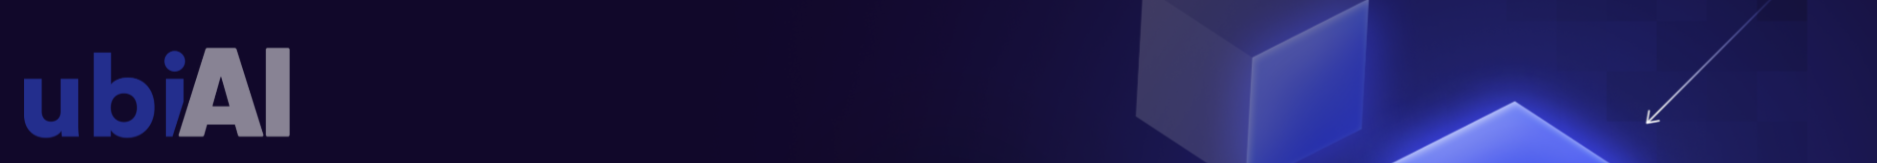

To ensure the quality and accuracy of our fine-tuning dataset, we will use the UBIAI platform and its data generation tool. This will allow us to create a high-quality instruction-response dataset tailored specifically for our document extraction task. Here’s a detailed breakdown of the labeling process:



- **Step 1:**
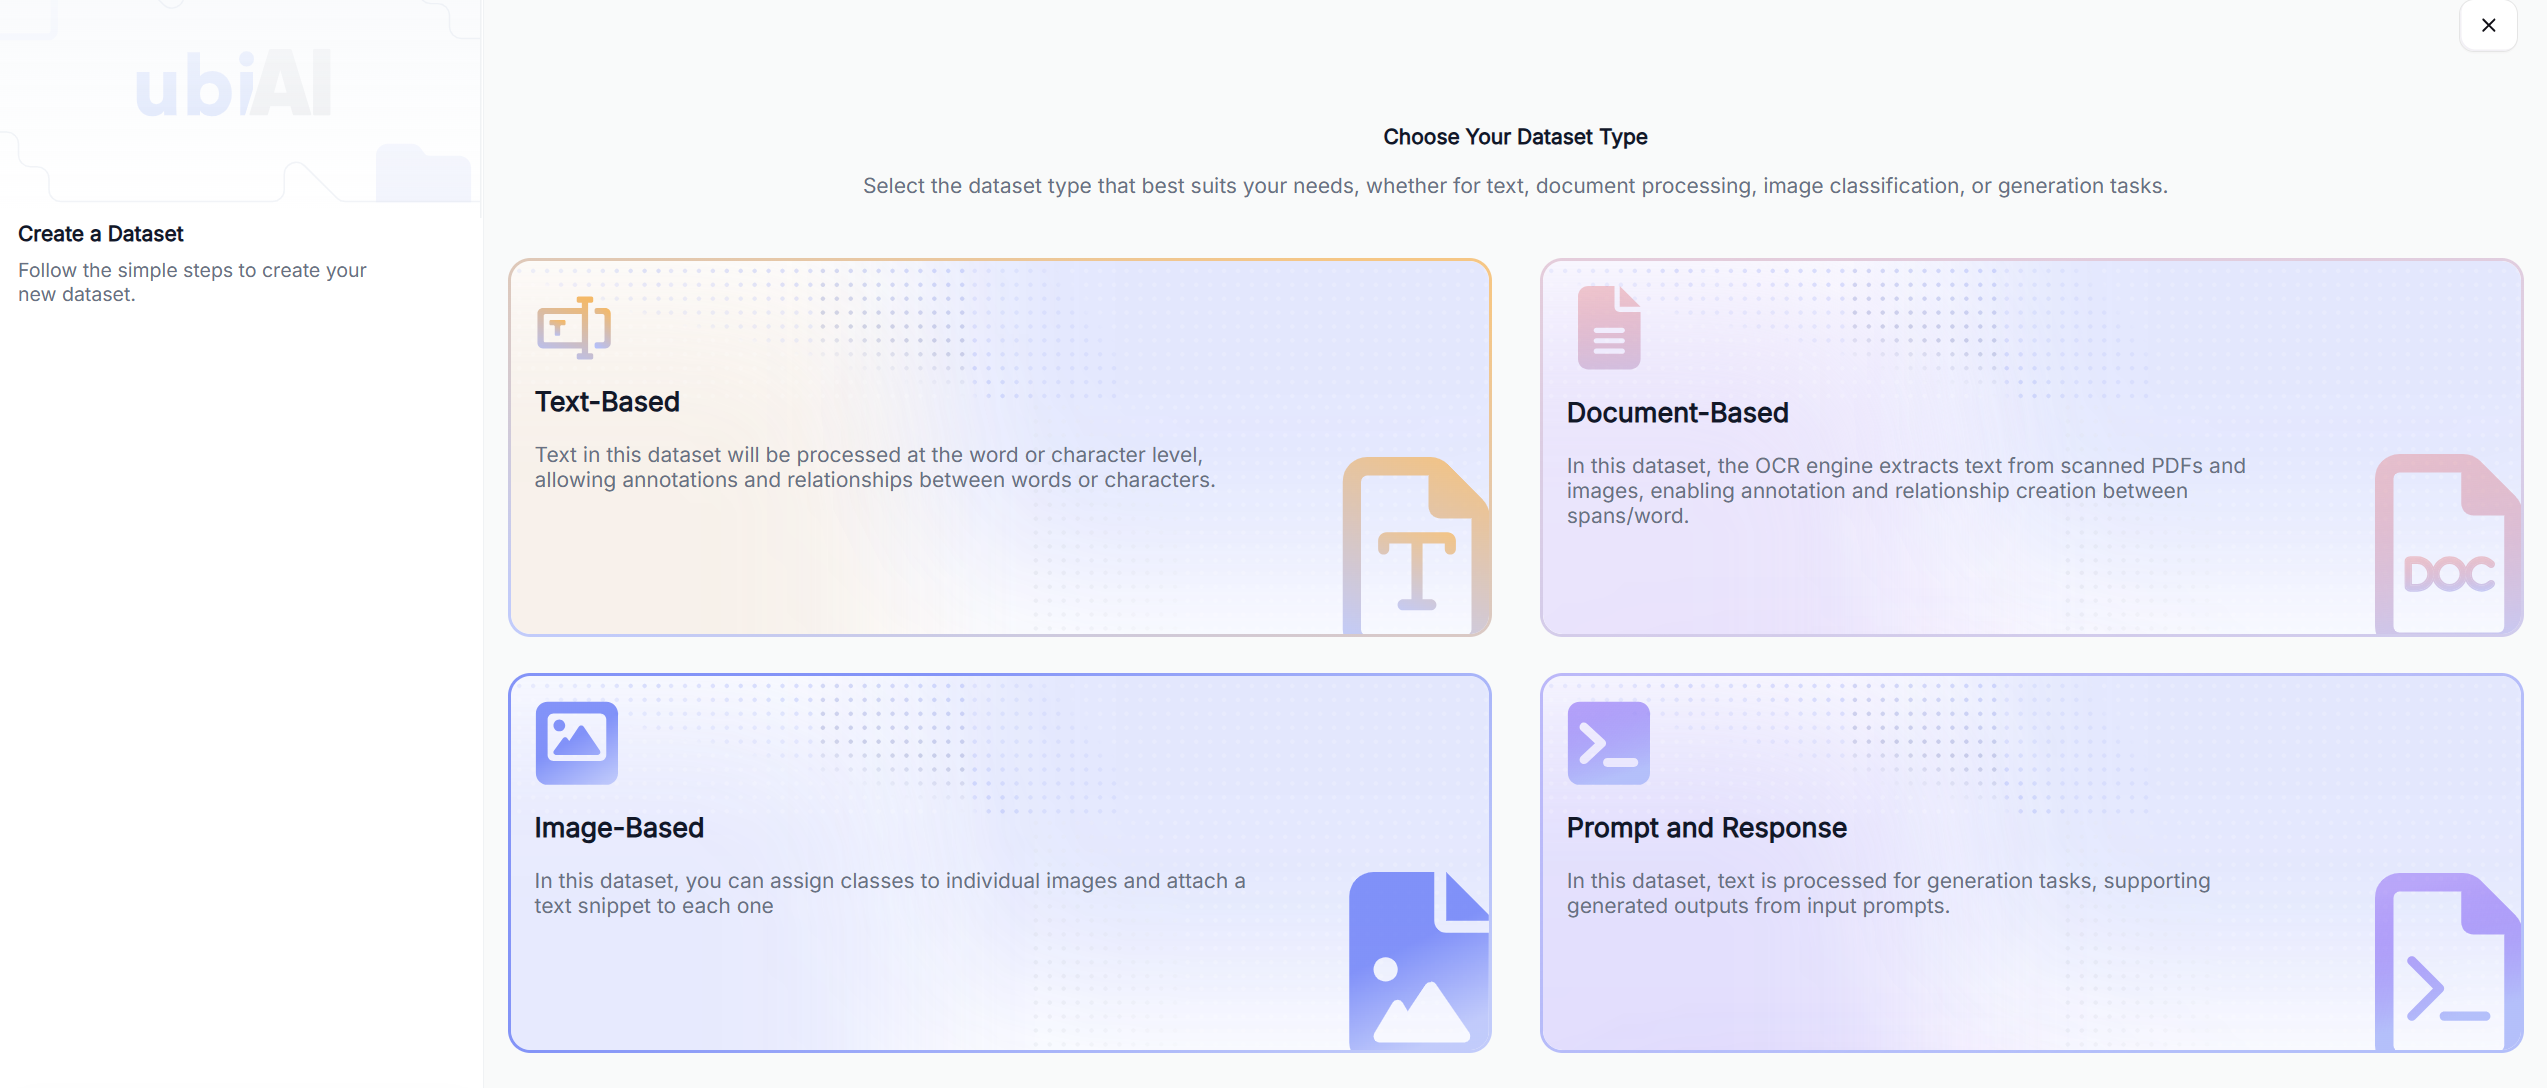

**Dataset Creation:** We began by creating a new dataset in UBIAI. The platform allows manual input, where we could type in text directly into the input field.

- **Step 2:**

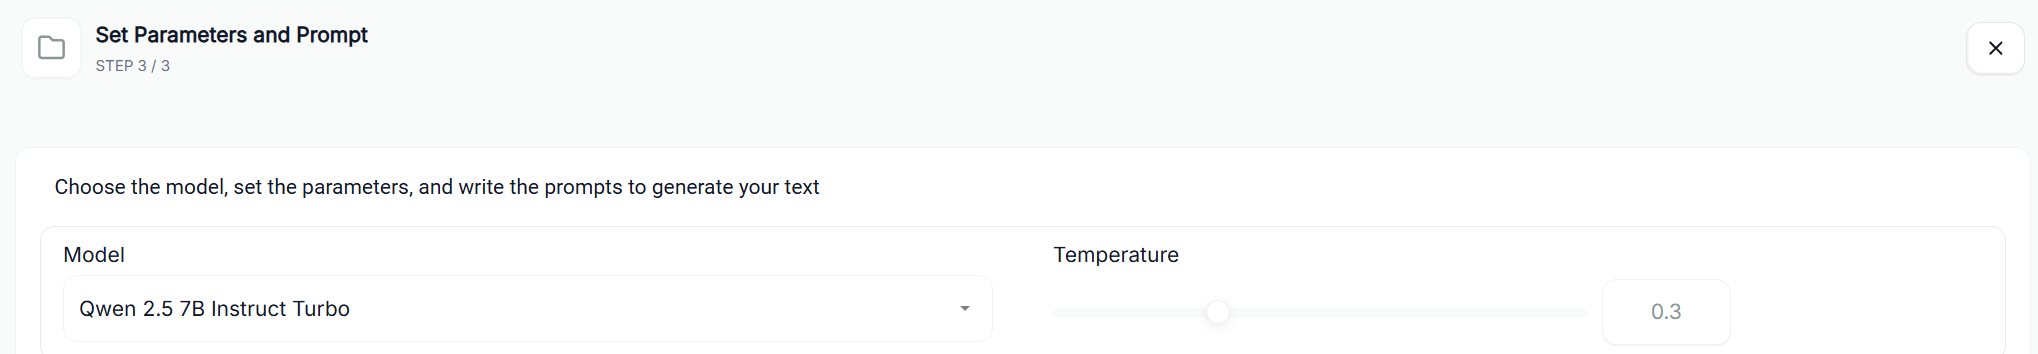

**Configuring Parameters:** Next, we configured the parameters. This included defining the temprature and selecting the appropriate model for generating responses.

- **Step 3:**

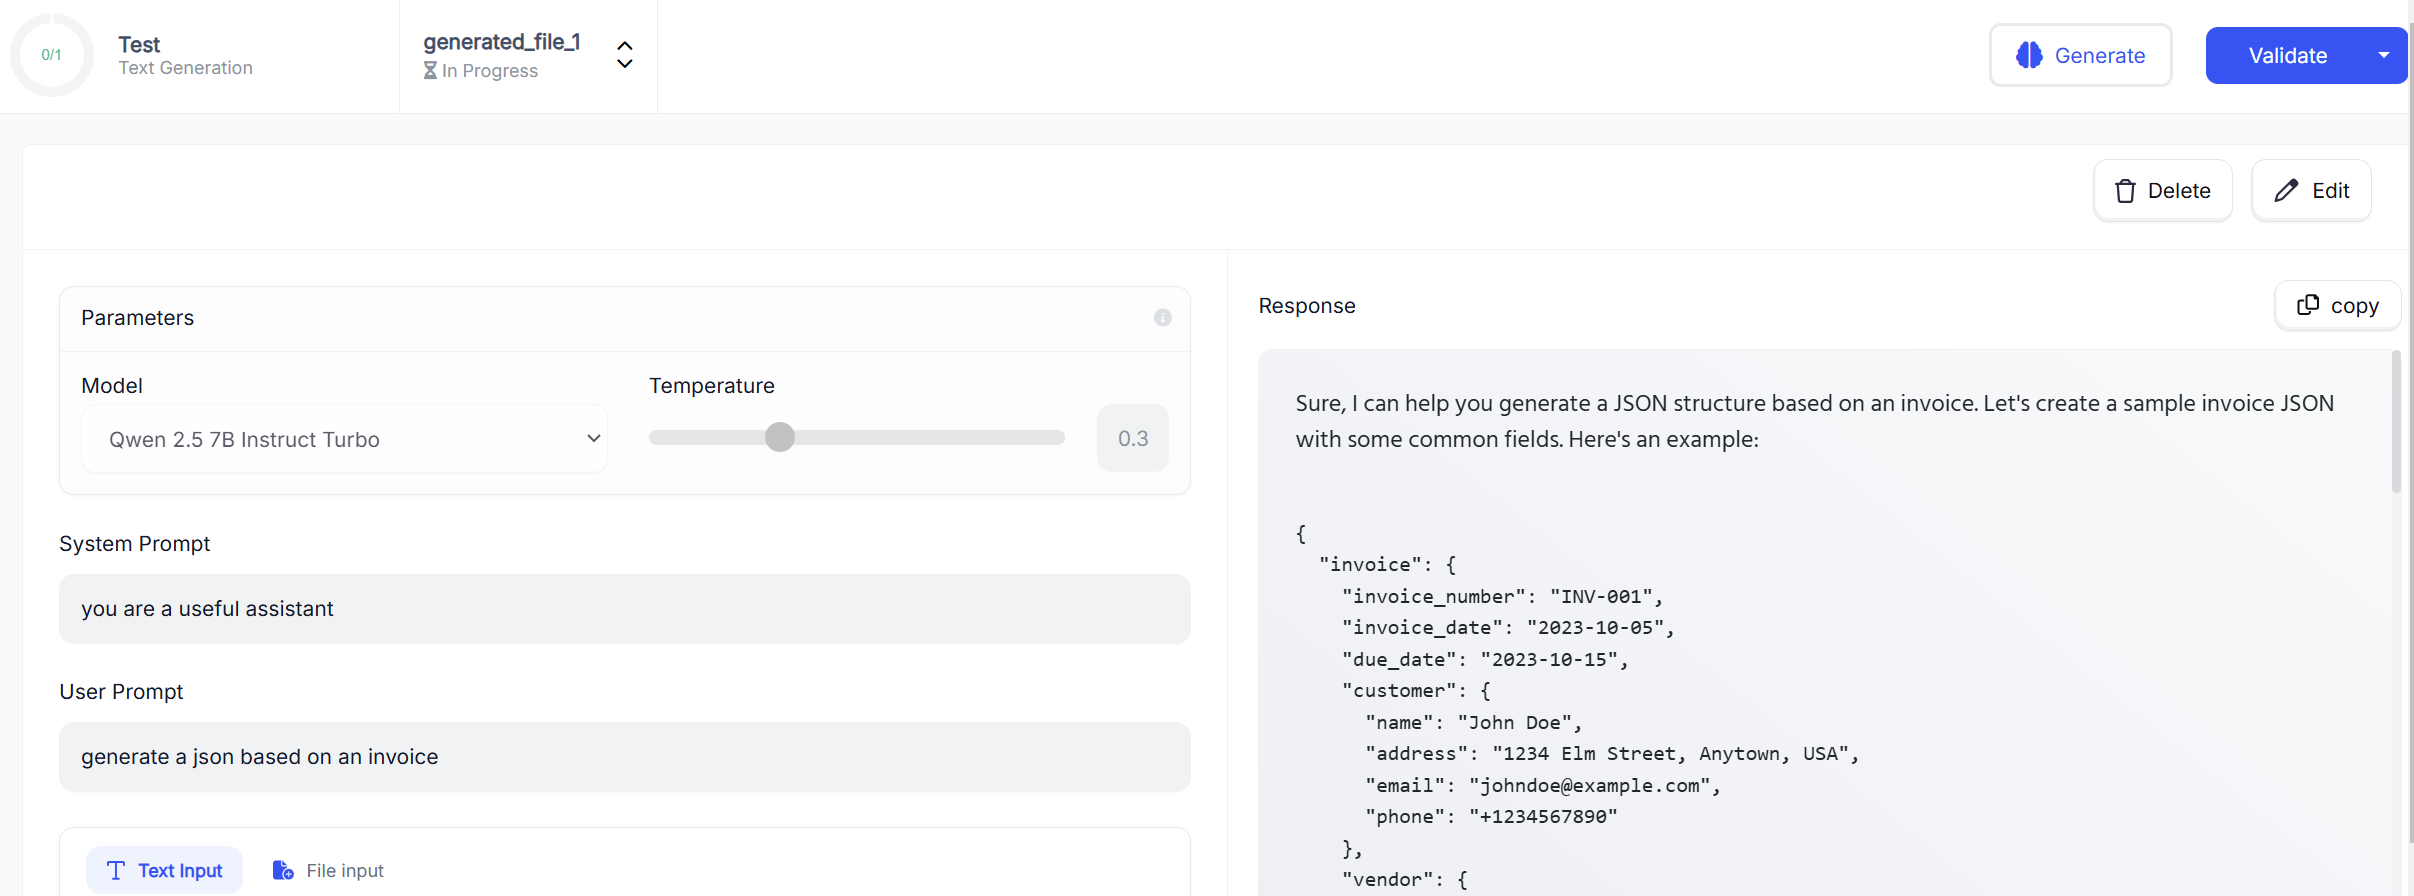

 **Generating Responses:** With the parameters set, we used UBIAI’s "Generate" button to create AI-generated responses based on our input. The platform automatically produced outputs that matched the query.

- **Step 4:**

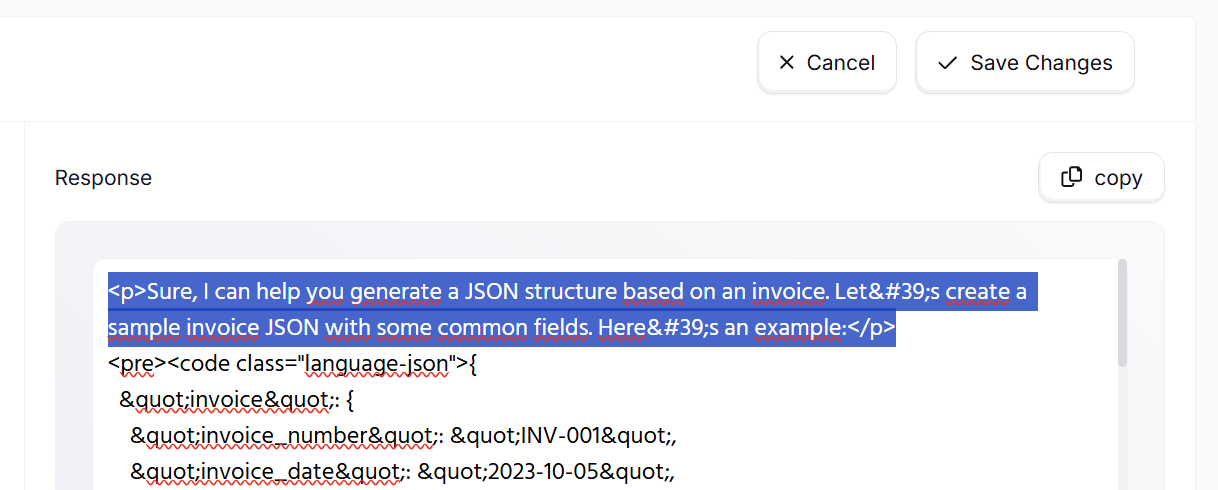

 **Refining the Output:** The initial outputs generated by the model is not always perfect. To ensure accuracy, we need to manually review and refine each response. This involved correcting errors, ensuring proper formatting, and validating the extracted information against the original input.

Once your data is prepared, you can download it and use it with this notebook. I uploaded mine to Hugging Face for easy access. Let's use it to fine-tune our model.

In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Extract the relevant information:

### Input:
{}

### Response:
{}"""


In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Extract the relevant information:

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token
def formatting_prompts_func(examples):
    inputs       = examples["Input"]
    outputs      = examples["Output"]
    texts = []
    for input, output in zip(inputs, outputs):

        text = alpaca_prompt.format(input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("melekmessoussi/LLM-Invoice-To-JSON", split = "train")


NameError: name 'tokenizer' is not defined

In [ ]:
dataset = dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [ ]:
print(dataset['text'][7])

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Extract the relevant information:

### Input:
INVOICE #: 98765432
ISSUE DATE: 03/11/2022

Seller Information
Company Name: Bright Electronics Ltd.
Address: 42 Innovation Avenue, San Francisco, CA 94105
Tax ID: 212-34-5678
IBAN: US22EVOC382401927465

Client Information
Client Name: Max Lacy
Address: 7803 Elm Street, Brooklyn, NY 11201
Tax ID: 543-21-9876

Itemized List
Item Description	Quantity	Unit Price	Subtotal
High Definition Smart TV	1	$850.00	$850.00
Bluetooth Headphones	2	$120.00	$240.00
Smart Home Security System (5 cameras)	1	$550.00	$550.00
4K Ultra HD Streaming Device	1	$200.00	$200.00
Summary
Subtotal: $1,840.00
Tax Rate: 7.5%
Tax Amount: $138.00
Total Due: $1,978.00
Terms & Conditions
Payment is due within 30 days of the invoice date.
Late payments may be subject to a 2% monthly fee.
Please make check

We define the training configuration and initialize the SFTTrainer.

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 55,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Map (num_proc=2):   0%|          | 0/10 [00:00<?, ? examples/s]

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 10 | Num Epochs = 55
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 55
 "-____-"     Number of trainable parameters = 29,933,568


Step,Training Loss
1,0.282700
2,0.487100
3,0.300900
4,0.319300
5,0.231700
6,0.391100
7,0.244000
8,0.231400
9,0.204000
10,0.200500


In [ ]:
import os
os.environ['HF_token'] = ''
HF_token = os.getenv('HF_token')

Lets save our model for later use.

In [ ]:
model.save_pretrained("lora_model")
tokenizer.save_pretrained("lora_model")
model.push_to_hub("melekmessoussi/Invo_Model_LoRA", token = HF_token)
tokenizer.push_to_hub("melekmessoussi/Invo_Model_LoRA", token = HF_token)

README.md:   0%|          | 0.00/581 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/120M [00:00<?, ?B/s]

Saved model to https://huggingface.co/melekmessoussi/Invo_Model_LoRA


  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

## **Testing Extraction After Fine-Tuning**

After fine-tuning, we assess the model’s performance on a different document.

In [ ]:
ModelInvoice = "melekmessoussi/Invo_Model_LoRA"

In [ ]:
Inmodel, Intokenizer = FastLanguageModel.from_pretrained(
    model_name= ModelInvoice,
    max_seq_length=70000,
    dtype=None,
    load_in_4bit=True,
)

FastLanguageModel.for_inference(Inmodel)

==((====))==  Unsloth 2025.2.15: Fast Qwen2 patching. Transformers: 4.48.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth: unsloth/qwen2.5-3b-bnb-4bit can only handle sequence lengths of at most 32768.
But with kaiokendev's RoPE scaling of 2.136, it can be magically be extended to 70000!


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 2048, padding_idx=151654)
        (layers): ModuleList(
          (0-35): 36 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora

In [ ]:
def extract_response(text):

    if isinstance(text, list):
        text = text[0]


    start_marker = "### Response:"
    start_index = text.find(start_marker)
    if start_index == -1:
        return None


    response_text = text[start_index + len(start_marker):].strip()


    end_marker = "<|endoftext|>"
    end_index = response_text.find(end_marker)
    if end_index != -1:
        response_text = response_text[:end_index].strip()

    return response_text

Let's see how the model performs after fine-tuning.

In [ ]:
alpaca_prompt= alpaca_prompt
model= Inmodel
tokenizer= Intokenizer
question = text_content
inputs = tokenizer(
    [
        alpaca_prompt.format(
            question,
            "",
        )
    ], return_tensors="pt"
).to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 3000, temperature=0.1, use_cache = True)
tokenizer.batch_decode(outputs)
answer= tokenizer.batch_decode(outputs)
answer= extract_response(answer)

In [ ]:
print(answer)

{
  "invoice": {
    "invoice_number": "123456",
    "client_name": "[Name]",
    "client_address": "[Street Accres], [City, ST ZIP]",
    "client_tax_id": "[123]",
    "invoice_due": "2020-01-08",
    "invoice_items": [
      {
        "description": "[Service Fee]",
        "amount": 230.00
      },
      {
        "description": "[Labor: hours at $75/hr]",
        "amount": 375.00
      },
      {
        "description": "[Parts]",
        "amount": 345.00
      }
    ],
    "summary": {
      "subtotal": 950.00,
      "taxable": 950.00,
      "tax_rate": 6.2502,
      "tax_due": 21.56,
      "total_due": 971.56
    },
    "invoice_header": {
      "invoice_number": "123456",
      "client_name": "[Name]",
      "client_address": "[Street Accres], [City, ST ZIP]",
      "invoice_due": "2020-01-08",
      "invoice_total": 971.56
    }
  }
}


 The output improved slightly as you can see. After fine-tuning, the output should be more structured, accurate, and relevant to our specific document type.

This concludes the notebook, but the journey of improvement will continue!